# Ultramarathon

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gpxpy
from scipy.signal import savgol_filter
np.set_printoptions(precision=2)  # For compact display.

In [227]:
data_path = "Ultramarathon_1.gpx"

## Import Data

In [228]:
with open(data_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    
# convert to a dataframe
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            # Extract extension data
            power = None
            hr = None
            cad = None
            
            if point.extensions:
                for ext in point.extensions:
                    if ext.tag == 'power':
                        power = int(ext.text) if ext.text else None
                    elif ext.tag.endswith('TrackPointExtension'):
                        for child in ext:
                            if child.tag.endswith('hr'):
                                hr = int(child.text) if child.text else None
                            elif child.tag.endswith('cad'):
                                cad = int(child.text) if child.text else None
            
            points.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
                'power': power,
                'heart_rate': hr,
                'cadence': cad
            })

df = pd.DataFrame.from_records(points)

## Smooth Elevation using savizky golay filter

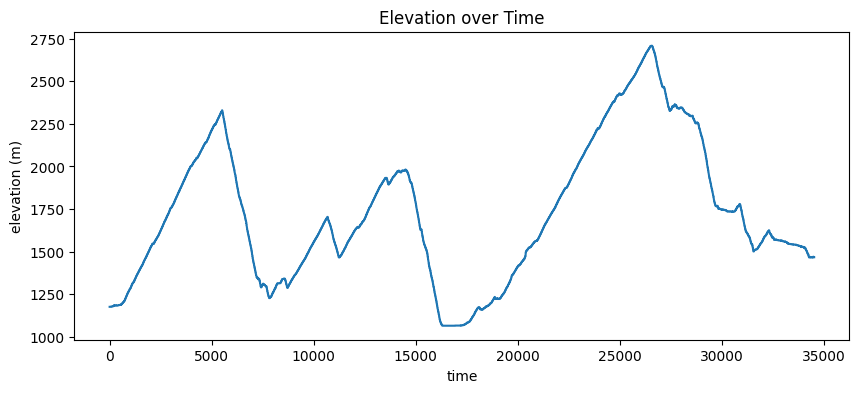

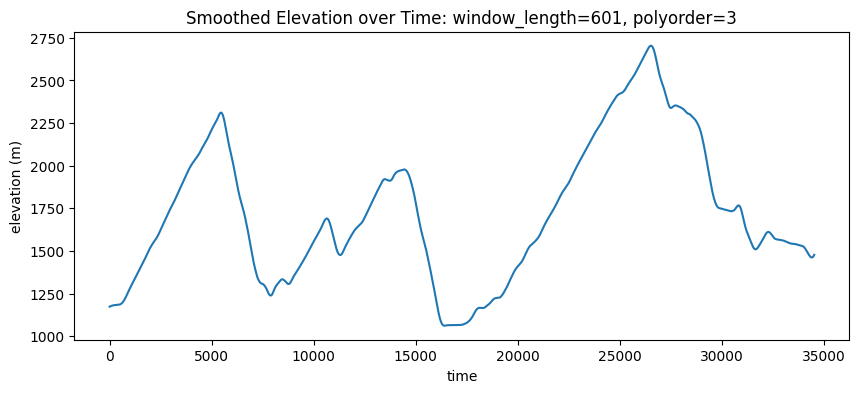

In [229]:
df.elevation.plot(figsize=(10,4))
plt.xlabel("time")
plt.title("Elevation over Time")
plt.ylabel("elevation (m)")
plt.show()

sv_window_length = 601  # must be odd
sv_polyorder = 3
df["elevation_smoothed"] = savgol_filter(df["elevation"], window_length=sv_window_length, polyorder=sv_polyorder)
df.elevation_smoothed.plot(figsize=(10,4))
plt.xlabel("time")
plt.title(f"Smoothed Elevation over Time: window_length={sv_window_length}, polyorder={sv_polyorder}")
plt.ylabel("elevation (m)")
plt.show()

Not sure if elevation should be included in the calculation of length

## Calculate the length travelled per timestep
We need the elevation over the distance travelled, not the elevation over time
- For example, when the runner stops to eat it looks like the track was maybe just flat, if we look at elevation over time. 

In [230]:
# This is horizonal distance
df["length"] = np.sqrt(df["latitude"].diff()**2 + df["longitude"].diff()**2) *111320 # convert degrees to meters 111320 m per degree 
df["length"] = df["length"].cumsum()

## Show Elevation over the distance travelled

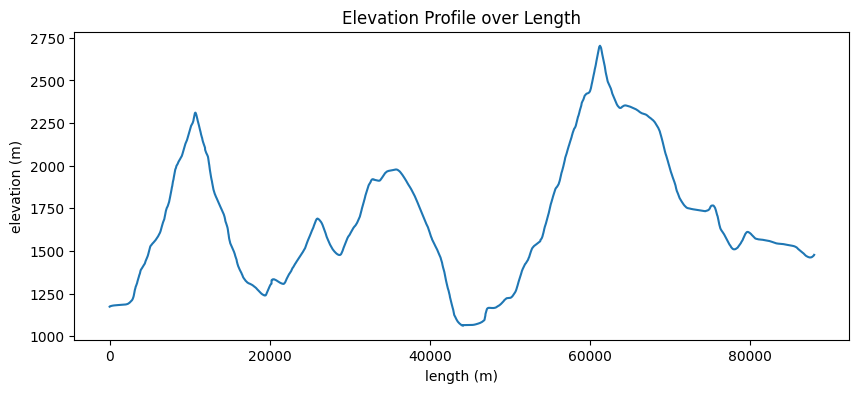

In [231]:
plt.figure(figsize=(10,4))
plt.plot(df["length"], df["elevation_smoothed"])
plt.xlabel("length (m)")
plt.ylabel("elevation (m)")
plt.title("Elevation Profile over Length")
plt.show()

## Show the mean Incline over the distance travelled

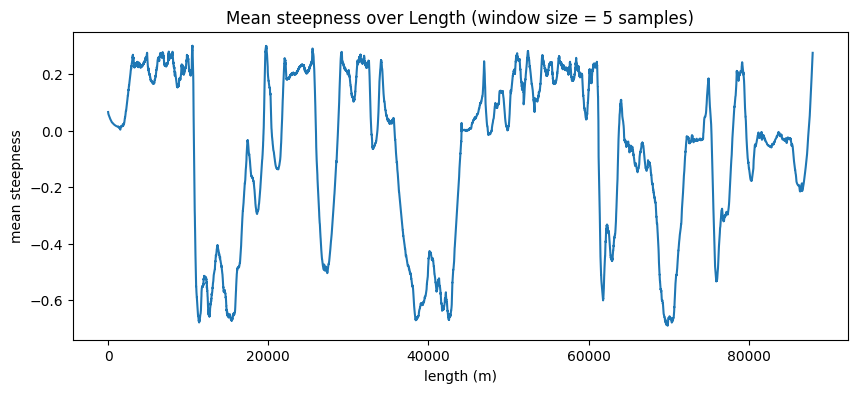

In [237]:
# Calculate elevation change between consecutive points
elevation_diff = df['elevation_smoothed'].diff()

# Calculate distance traveled between consecutive points
distance_diff = df['length'].diff()

# Calculate steepness (grade/slope)
df['steepness'] = elevation_diff / distance_diff



window_size = 5 
df['mean_steepness'] = df["elevation_smoothed"].diff().rolling(window=window_size).mean()
plt.figure(figsize=(10,4))

plt.plot(df["length"], df["mean_steepness"])
plt.title(f"Mean steepness over Length (window size = {window_size} samples)")
plt.xlabel("length (m)")
plt.ylabel("mean steepness")
plt.show()

## Check for significant changes in incline

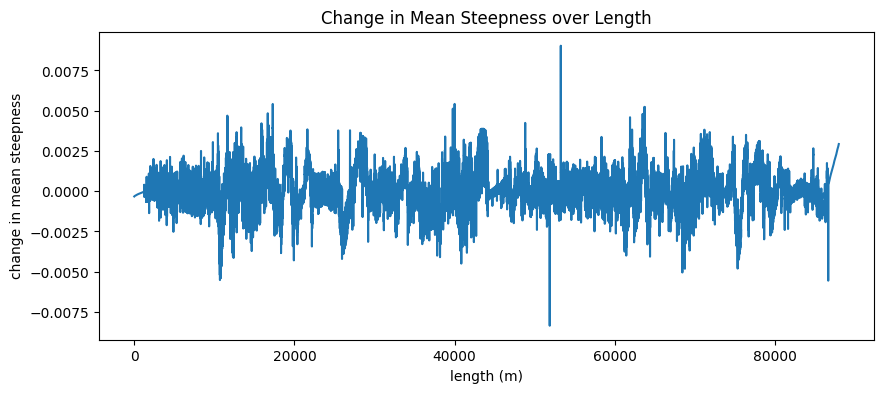

<Figure size 1000x400 with 0 Axes>

In [238]:
plt.figure(figsize=(10,4))
plt.plot(df["length"], df["mean_steepness"].diff())
plt.title("Change in Mean Steepness over Length")
plt.xlabel("length (m)")
plt.ylabel("change in mean steepness")
plt.figure(figsize=(10,4))
plt.show()

In [239]:
df["mean_steepness"].isna().sum()
df.mean_steepness.bfill(inplace=True)

In [240]:
changing_points = []
incline_threshold = 0.25

for idx, row in df.iterrows():
    if idx ==0:
        
        changing_points.append(row)
        continue
    last_changing_point = changing_points[-1]
    
        
    if abs(row["mean_steepness"] - last_changing_point["mean_steepness"]) > incline_threshold:
        changing_points.append(row)
    
for point in changing_points:
    print(f"Length: {point['length']:.2f} m, Mean Steepness: {point['mean_steepness']:.4f}")

Length: nan m, Mean Steepness: 0.0662
Length: 10764.96 m, Mean Steepness: -0.1844
Length: 10904.85 m, Mean Steepness: -0.4344
Length: 17092.53 m, Mean Steepness: -0.1841
Length: 19473.38 m, Mean Steepness: 0.0665
Length: 26172.67 m, Mean Steepness: -0.1852
Length: 26651.45 m, Mean Steepness: -0.4358
Length: 28342.25 m, Mean Steepness: -0.1852
Length: 28804.47 m, Mean Steepness: 0.0649
Length: 36253.30 m, Mean Steepness: -0.1863
Length: 37158.31 m, Mean Steepness: -0.4366
Length: 43789.15 m, Mean Steepness: -0.1861
Length: 46209.68 m, Mean Steepness: 0.0640
Length: 61321.95 m, Mean Steepness: -0.1866
Length: 61472.75 m, Mean Steepness: -0.4381
Length: 63584.26 m, Mean Steepness: -0.1876
Length: 63893.77 m, Mean Steepness: 0.0625
Length: 67948.02 m, Mean Steepness: -0.1885
Length: 68758.43 m, Mean Steepness: -0.4421
Length: 71845.67 m, Mean Steepness: -0.1914
Length: 74628.98 m, Mean Steepness: 0.0588
Length: 75517.84 m, Mean Steepness: -0.1950
Length: 75753.64 m, Mean Steepness: -0.4464

## Plot Results with change lines

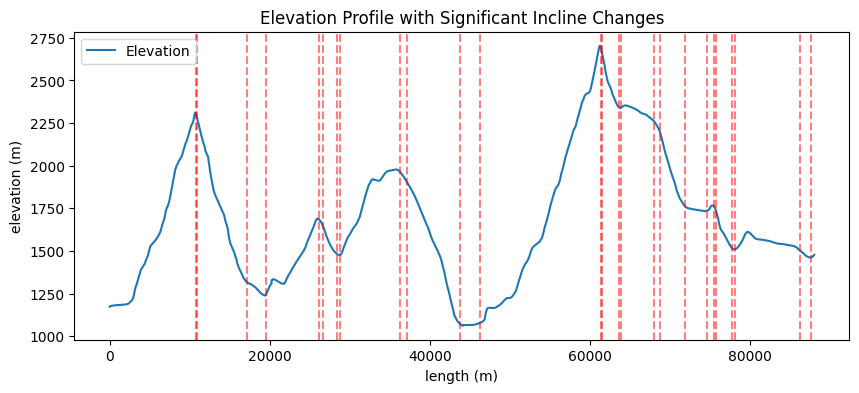

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df["length"], df["elevation_smoothed"], label="Elevation")
for point in changing_points:
    plt.axvline(x=point["length"], color='r', linestyle='--', alpha=0.3)
plt.title("Elevation Profile with Significant Incline Changes")
plt.xlabel("length (m)")
plt.ylabel("elevation (m)")
plt.legend()
plt.show()